# Valencia Airbnb listings Analysis
## by Eduardo Burgoa


## Businesse Understanding
The purpose of the analysis is to gain more understanding of the characteristics of Airbnb offer in the city of Valencia. I am focusing on answering the following questions:

- What neighbourhoods have highest average Airbnb price listings in the city of Valencia?
- What neighbourhoods have greater proportion of listings with multiple listing-owners?
- What factors are related to price of Airbnb in house listings?



## Data understanding 
This dataset includes 7233 Airbnb apartments in the city of Valencia updated on September 30th of 2019. This dataset has been colleted by Murray Cox from public information in Airbnb web page anonimazing any personal data. The purpose of this data collection work is adding data to key metrics so anyone can analyse how Airbnb is being used to compete with the residential housing market.

Let's explore the variables included in the dataset.

In [3]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [4]:
# Import Data
df_listings = pd.read_csv('listings.csv')
df_neighbourhoods = pd.read_csv('neighbourhoods.csv')


In [5]:
print("Listings")
print(df_listings.info(max_cols=106))
print("Neighbourhoods")
print(df_neighbourhoods.info())

Listings
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7233 entries, 0 to 7232
Data columns (total 106 columns):
id                                              7233 non-null int64
listing_url                                     7233 non-null object
scrape_id                                       7233 non-null int64
last_scraped                                    7233 non-null object
name                                            7233 non-null object
summary                                         6897 non-null object
space                                           5412 non-null object
description                                     7041 non-null object
experiences_offered                             7233 non-null object
neighborhood_overview                           4874 non-null object
notes                                           3328 non-null object
transit                                         4523 non-null object
access                                          3702 non-

In [12]:
df_listings[['name', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'price', 'monthly_price','host_total_listings_count']].head()

,name,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,price,monthly_price,host_total_listings_count
0,VALENCIA HISTORIC HOUSE 50M BEACH,Poblados Marítimos,LA MALVA-ROSA,POBLATS MARITIMS,$150.00,NaN,3.0
1,Valencia: El Saler Beach and Albufera Lake,NaN,EL SALER,POBLATS DEL SUD,$100.00,"$1,000.00",1.0
2,beautiful apartment wifi,La Saïdia,MORVEDRE,LA SAIDIA,$45.00,$870.00,2.0
3,Delight in city center,Ciutat Vella,LA SEU,CIUTAT VELLA,$100.00,$700.00,1.0
4,Modern and bright Duplex 3 Bedrooms Center Wi-Fi,Ciutat Vella,EL CARME,CIUTAT VELLA,$134.00,NaN,6.0


In [7]:
df_neighbourhoods.head()

,neighbourhood_group,neighbourhood
0,ALGIROS,CIUTAT JARDI
1,ALGIROS,LA CARRASCA
2,ALGIROS,L'AMISTAT
3,ALGIROS,LA VEGA BAIXA
4,ALGIROS,L'ILLA PERDUDA


The only data we need to answer our questions of interest is `listings.csv` as neighbourhoods names are also included in it.

## Data Preparation

#### Assesment
- `price` is a string and should be numeric.

#### Cleaning Price

In [16]:
df_listings['price'] = df_listings['price'].str.replace('$', '')
df_listings['price'] = df_listings['price'].str.replace(',', '')
df_listings['price'] = pd.to_numeric(df_listings['price'])

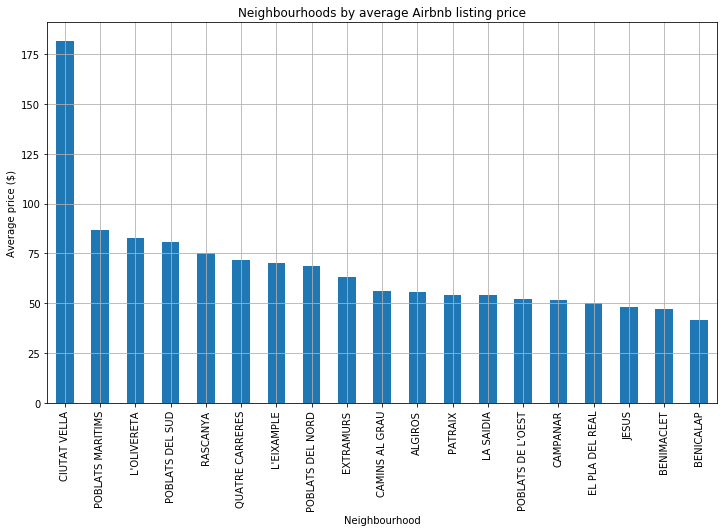

In [41]:
neigbourhoods_by_price = df_listings.groupby('neighbourhood_group_cleansed')['price'].mean()
neigbourhoods_by_price = neigbourhoods_by_price.nlargest(len(neigbourhoods_by_price))

neigbourhoods_by_price.plot('bar', figsize=(12,7))
plt.title('Neighbourhoods by average Airbnb listing price')
plt.xlabel('Neighbourhood')
plt.ylabel('Average price ($)')
plt.grid();

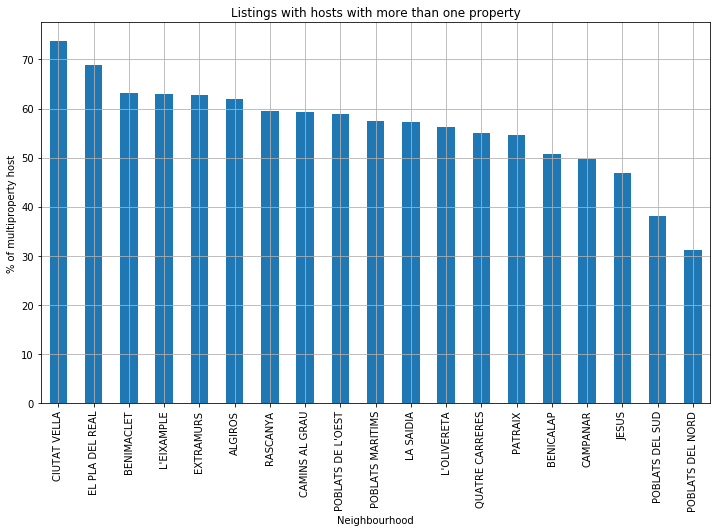

In [53]:
totals_by_neibourhood = df_listings.groupby('neighbourhood_group_cleansed')['id'].count()
multiproperty_by_neighbourhood = df_listings.query('host_total_listings_count >= 2').groupby('neighbourhood_group_cleansed')['id'].count()
proportion = multiproperty_by_neighbourhood/totals_by_neibourhood*100

proportion = proportion.nlargest(len(proportion))

proportion.plot('bar', figsize=(12,7))
plt.title('Listings with hosts with more than one property')
plt.xlabel('Neighbourhood')
plt.ylabel('% of multiproperty host')
plt.grid();

## Model

## Evaluation

## Deployment